## Importing Data

In [1]:
import pandas as pd
data = pd.read_csv("reviews.csv")
reviews_data = data["reviews.text"]
reviews_data[0]

'This hotel was nice and quiet. Did not know, there was train track near by. But it was only few train passed during our stay. Best Western changed hotel classification. The Plus category are not the same as before.'

## Lemmatizing words to convert aspects to their base form

In [2]:
from nltk.stem import WordNetLemmatizer

wm = WordNetLemmatizer()
import re 

reviews = []

for i in range(0,len(reviews_data)):
    review = re.sub("\.\.+", ". ", str(reviews_data[i]))
    review = review.lower()
    words_list = [wm.lemmatize(word) for word in review.split()]
    review = " ".join(words_list)
    reviews.append(review)
    
reviews[0]

'this hotel wa nice and quiet. did not know, there wa train track near by. but it wa only few train passed during our stay. best western changed hotel classification. the plus category are not the same a before.'

## Splitting sentences in a review

In [3]:
import spacy

nlp = spacy.load("en_core_web_sm")

sentence_list = []

for statement in reviews:
    tagged = nlp(statement)
    for sent in tagged.sents:
        sentence_list.append((str(sent)))
    
sentence_list[0]

'this hotel wa nice and quiet.'

## Splitting sentences with 'comma' seperation

In [4]:
sentence_list_final = []

for sentence in sentence_list:
    sentences = sentence.split(", ")
    for s in sentences:
        sentence_list_final.append(s)
        
sentence_list_tagged = []
for sentence in sentence_list_final:
    tagged = nlp(sentence)
    
    sentence_list_tagged.append(tagged)
    
sentence_list_tagged[0]

this hotel wa nice and quiet.

# Splitting sentence with conjunctions

In [5]:
sentence_list_final = []

# Splitting sentences based on conjunction words
for s1 in sentence_list_tagged:
    split_sentences_1 = str(s1).split(" and ")
    for s2 in split_sentences_1:
        split_sentences_2 = str(s2).split(" but ")
        for s3 in split_sentences_2:
            split_sentences_3 = str(s3).split(" or ")
            
            for s in split_sentences_3:
                sentence_list_final.append(s)
    
# Converting into tagged sentence
sentence_list_tagged = []
for sentence in sentence_list_final:
    sent = sentence.lower()
    tagged = nlp(sent)
    
    sentence_list_tagged.append(tagged)
    
sentence_list_tagged[0]

this hotel wa nice

## Checking POS tags

In [6]:
# for sentence in sentence_list_tagged:
#     for word in sentence:
#         print(word.text, word.pos_, word.dep_)
#         pass

## Applying Vader Sentiment Analysis Model to our statments

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment_list = []

vad = SentimentIntensityAnalyzer()

for i,sentence in enumerate(sentence_list_tagged):
    polarity_dict = vad.polarity_scores(str(sentence))
    
    if polarity_dict["compound"] == 0:
        sentiment_list.append([str(sentence), [token.text for token in sentence if token.pos_ == "NOUN" and (token.dep_ == "nsubj" or token.dep_ == "ROOT")], "Neutral"])
        
    elif polarity_dict["compound"] > 0:
        sentiment_list.append([str(sentence),[token.text for token in sentence if token.pos_ == "NOUN" and (token.dep_ == "nsubj" or token.dep_ == "ROOT")],"Positive"])
        
    else:
        sentiment_list.append([str(sentence),[token.text for token in sentence if token.pos_ == "NOUN" and (token.dep_ == "nsubj" or token.dep_ == "ROOT")],"Negative"])
        
sentiment_list[0]

['this hotel wa nice', ['hotel'], 'Positive']

## Converting results into Dataset

In [8]:
import pandas as pd

data = pd.DataFrame(sentiment_list, columns = ["Text", "Aspect", "Sentiment"])

## Dropping rows determining no aspects

In [9]:
index_list = []

for i in range(len(data)):
    if data["Aspect"][i] == []:
        index_list.append(i)
        
data = data.drop(index_list, axis = 0)
data

,Text,Aspect,Sentiment
0,this hotel wa nice,[hotel],Positive
5,best western changed hotel classification.,[classification],Positive
6,the plus category are not the same a before.,[category],Neutral
8,the living space.,[space],Neutral
9,the sofa bed wasn't very good i had back disco...,[bed],Negative
...,...,...,...
162582,arcade game to cure your boredom!,[game],Negative
162583,the owner are amazing!thank you!,[owner],Neutral
162584,clean facility just off freeway .,[facility],Positive
162585,staff friendly,[staff],Positive


### Converting Sentiments into numeric representations

In [10]:
def sentiment_score(row):
    if row["Sentiment"] == "Positive":
        return 5
    
    elif row["Sentiment"] == "Neutral":
        return 3
    
    elif row["Sentiment"] == "Negative":
        return 1
    
data["Score"] = data.apply(sentiment_score, axis = 1)
data

,Text,Aspect,Sentiment,Score
0,this hotel wa nice,[hotel],Positive,5
5,best western changed hotel classification.,[classification],Positive,5
6,the plus category are not the same a before.,[category],Neutral,3
8,the living space.,[space],Neutral,3
9,the sofa bed wasn't very good i had back disco...,[bed],Negative,1
...,...,...,...,...
162582,arcade game to cure your boredom!,[game],Negative,1
162583,the owner are amazing!thank you!,[owner],Neutral,3
162584,clean facility just off freeway .,[facility],Positive,5
162585,staff friendly,[staff],Positive,5


In [11]:
# data.to_csv("output_FEMA.csv")

### Checking aspects mentioned in most reviews

In [12]:
aspect_list = []

for data_aspect_list in data["Aspect"]:
    for aspect in data_aspect_list:
        aspect_list.append(aspect)

from nltk.probability import FreqDist

freq_counter = FreqDist()

for aspect in aspect_list:
    freq_counter[aspect] += 1
    
aspects_count = pd.DataFrame.from_dict(freq_counter, orient = "index", columns = ["Count"])
aspects_count = aspects_count.sort_values(by = "Count", ascending = False)
aspects_count

,Count
room,5958
staff,4640
hotel,3577
location,2089
breakfast,1865
...,...
gambling,1
wynn,1
gaming,1
seclusion,1


### Finding Average Aspect Rating

In [13]:
aspects_unique = aspects_count.index.to_list()
aspects_unique[0]

'room'

In [14]:
aspect_rating_list = []

for aspect in aspects_unique:
    rating_sum = 0
    
    for  i in range(len(data)):
        for a in data["Aspect"].iloc[i]:
            if a == aspect:
                rating_sum += data["Score"].iloc[i]
    
    aspect_rating_list.append(rating_sum)

aspect_rating_list[0]

23286

In [15]:
aspects_count["Rating_Sum"] = aspect_rating_list

In [16]:
aspects_count["Rating"] = round((aspects_count["Rating_Sum"]/aspects_count["Count"]),1)
aspects_count.to_csv("aspect_ratings.csv")
aspects_count

,Count,Rating_Sum,Rating
room,5958,23286,3.9
staff,4640,20560,4.4
hotel,3577,14417,4.0
location,2089,8955,4.3
breakfast,1865,7755,4.2
...,...,...,...
gambling,1,1,1.0
wynn,1,5,5.0
gaming,1,5,5.0
seclusion,1,5,5.0


### Visualization

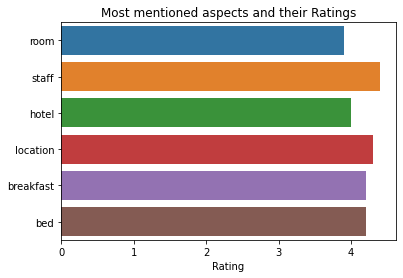

In [17]:
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

aspects_count_plot = aspects_count.head(6)

sns.barplot(y = aspects_count_plot.index, x = aspects_count_plot["Rating"])
plt.title("Most mentioned aspects and their Ratings", loc = "center")
plt.xticks(rotation =0)
plt.show()

#### Word Cloud

In [18]:
data_pos = aspects_count[aspects_count["Rating"]>3]
data_neu = aspects_count[aspects_count["Rating"]==3]
data_neg = aspects_count[aspects_count["Rating"]<3]

pos_list = []
neg_list = []
neu_list = []

for i,count in enumerate(data_pos["Count"]):
    for j in range(count):
        pos_list.append(data_pos.index[i])

for i,count in enumerate(data_neu["Count"]):
    for j in range(count):
        neu_list.append(data_neu.index[i])
        
for i,count in enumerate(data_neg["Count"]):
    for j in range(count):
        neg_list.append(data_neg.index[i])
        
data_pos = " ".join(pos_list)
data_neg = " ".join(neg_list)
data_neu = " ". join(neu_list)

#### Creating WordCloud for Positive Aspects

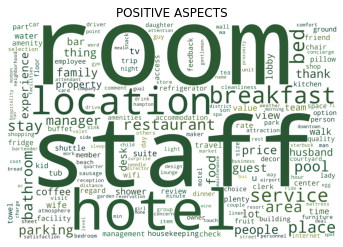

In [19]:
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from PIL import Image

green_mask = np.array(Image.open("green_pattern.jpg"))
green_color = ImageColorGenerator(green_mask)

wc1 = WordCloud(mask = green_mask, color_func = green_color, background_color = "white", collocations = False).generate(data_pos)

plt.imshow(wc1)
plt.title("POSITIVE ASPECTS")
plt.axis("off")
plt.show()

#### Creating WordCloud for Neutral Aspects

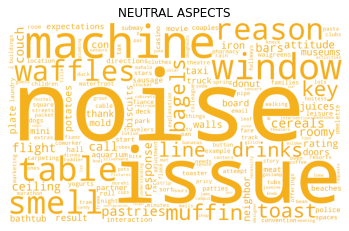

In [20]:
ochre_mask = np.array(Image.open("yellow_pattern.jpg"))
ochre_color = ImageColorGenerator(ochre_mask)

wc2 = WordCloud(mask = ochre_mask, color_func = ochre_color, background_color = "white", collocations = False).generate(data_neu)

plt.imshow(wc2)
plt.title("NEUTRAL ASPECTS")
plt.axis("off")
plt.show()

#### Creating WordCloud for Negative Aspects 

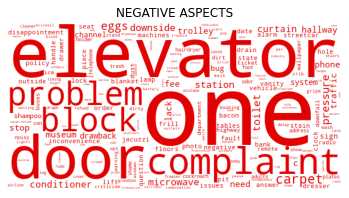

In [21]:
red_mask = np.array(Image.open("red_pattern.jpg"))
red_color = ImageColorGenerator(red_mask)

wc3 = WordCloud(mask = red_mask, color_func = red_color, background_color = "white", collocations = False).generate(data_neg)

plt.imshow(wc3)
plt.title("NEGATIVE ASPECTS")
plt.axis("off")
plt.show()